In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

C:\Users\Omar Ben Emad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

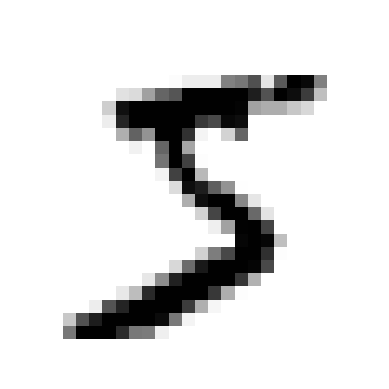

In [3]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off");

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

In [6]:
y[0]

5

In [7]:
%%time
example_images = X[:100]
N = 100
plt.figure(figsize=(20,20))

for i,img in enumerate(example_images):
  plt.subplot(np.ceil(N**.5), np.ceil(N**.5), i+1)
  plt.imshow(img.reshape(28,28), cmap='binary')
  plt.axis('off')

ValueError: Number of rows must be a positive integer, not 10.0

<Figure size 2000x2000 with 0 Axes>

In [ ]:
# EXTRA
def plot_digits(instances, images_per_row=10):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary)
    plt.axis("off")

CPU times: user 27.6 ms, sys: 987 µs, total: 28.6 ms
Wall time: 29.7 ms


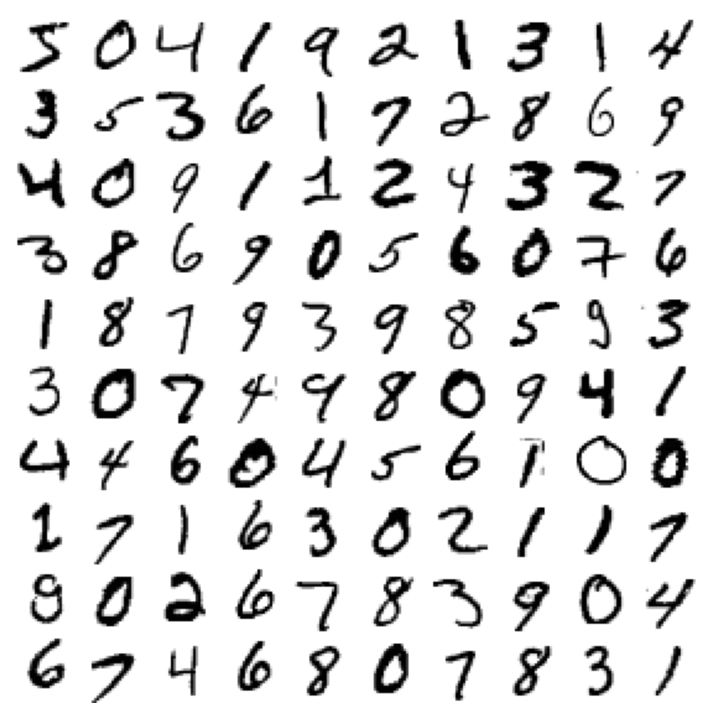

In [ ]:
%%time
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit]) # True = 5

array([ True])

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
import pandas as pd
pd.Series(y_train).value_counts(normalize=True)

1    0.112367
7    0.104417
3    0.102183
2    0.099300
9    0.099150
0    0.098717
6    0.098633
8    0.097517
4    0.097367
5    0.090350
dtype: float64

# Performance Measures

### Measuring Accuracy Using Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# Each row in a confusion matrix represents an actual class, while each column represents a predicted class

# 53892 TN
# 3530 TP
# 1891 FN
# 687 FP

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) 

In [ ]:
y_some_digit_pred # The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred # This confirms that raising the threshold decreases recall

array([False])

##### How do you decide which threshold to use?

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
recalls.shape

(59967,)

In [ ]:
thresholds.shape

(59966,)

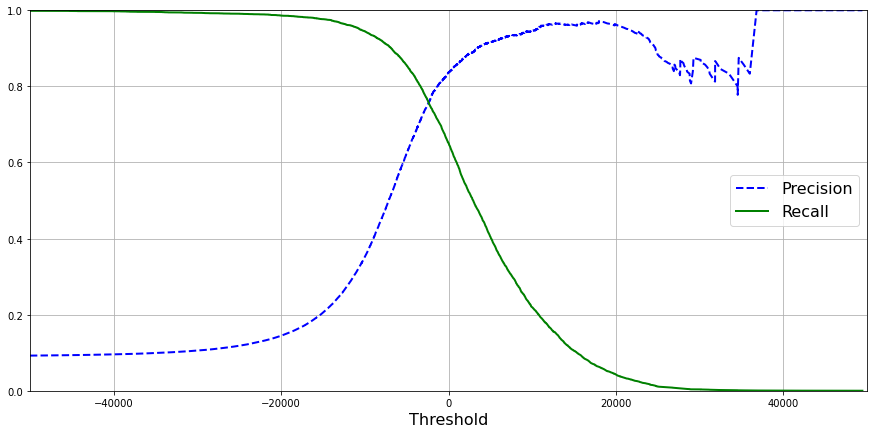

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid()                              
    plt.axis([-50000, 50000, 0, 1])             


# np.argmax() will give you the first index of the maximum value, which in this case means the first True value
# recall_90_precision = recalls[np.argmax(precisions >= 0.90)] 
# threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(15, 7))                                                               
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
# plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
# plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
# plt.plot([threshold_90_precision], [0.9], "ro")                                            
# plt.plot([threshold_90_precision], [recall_90_precision], "ro");

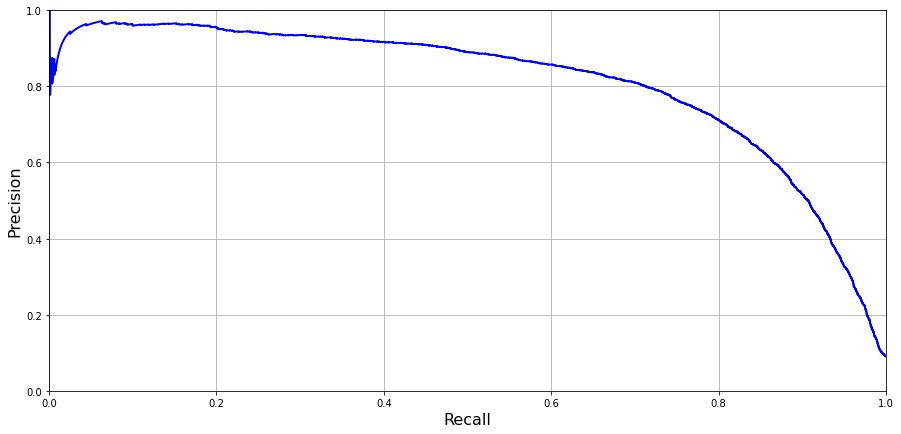

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid()

plt.figure(figsize=(15, 7))
plot_precision_vs_recall(precisions, recalls)
# plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
# plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
# plt.plot([recall_90_precision], [0.9], "ro")

##### Suppose you decide to aim for 90% precision.

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
# To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can run this code:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

##### Let’s check these predictions’ precision and recall

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

##### Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast. A high-precision classifier is not very useful if its recall is too low!

##### If someone says, “Let’s reach 99% precision,” you should ask, “At what recall?”

### The ROC Curve


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

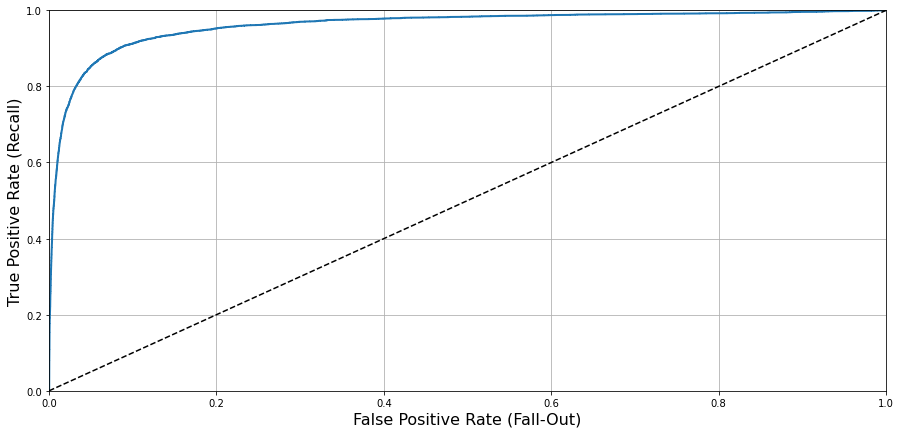

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(15, 7))                                    
plot_roc_curve(fpr, tpr)
# fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
# plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
# plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
# plt.plot([fpr_90], [recall_90_precision], "ro");

# the red circle highlights the chosen ratio (at 47.9% recall)

##### Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

### AUC Score

##### One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### Let’s now train a RandomForestClassifier and compare its ROC curve and ROC AUC score to those of the SGDClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba") # the RandomForestClassifier class does not have a decision_function() method. Instead, it has a predict_proba() method

In [ ]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

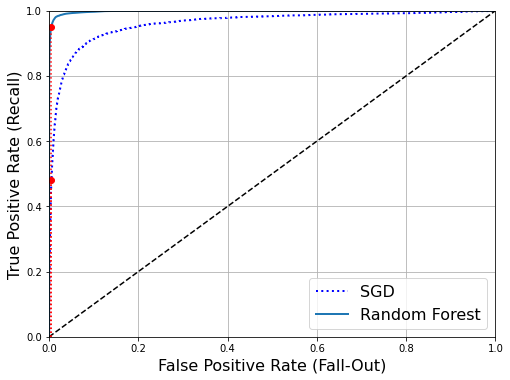

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16);

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass Classification


In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**Warning**: the following two cells may take close to 30 minutes to run, or more depending on your hardware.



In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

# array([0.87365, 0.85835, 0.8689])

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# array([0.8983, 0.891 , 0.9018])

array([0.8983, 0.891 , 0.9018])

# Error Analysis


In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

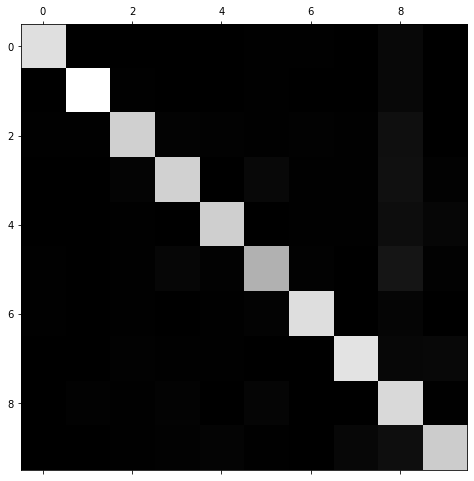

In [ ]:
plt.figure(figsize=(10,8))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1);

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

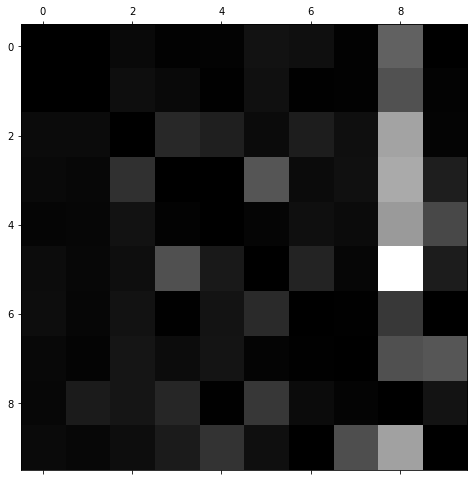

In [ ]:
np.fill_diagonal(norm_conf_mx, 0) # Fill the diagonal with zeros to keep only the errors

plt.figure(figsize=(10,8))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1);

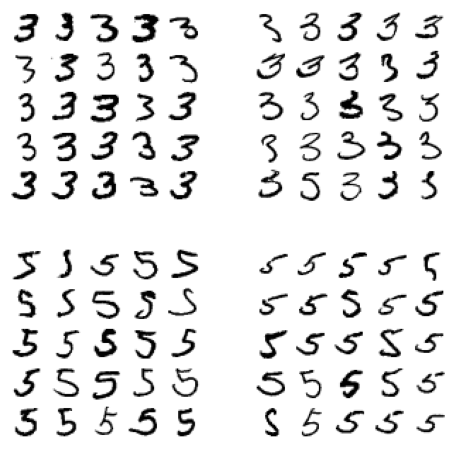

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]   
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

Warning: the following cell may take a very long time (possibly hours depending on your hardware).



In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 0.976

0.976410265560605

# Multioutput Classification

In [ ]:
# Let’s take a peek at an image from the test set (yes, we’re snooping on the test data, so you should be frowning right now):

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

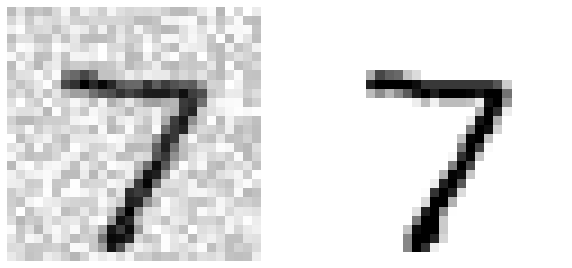

In [ ]:
some_index = 0

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(X_test_mod[some_index].reshape(28,28), cmap='binary'), plt.axis('off')
plt.subplot(1,2,2); plt.imshow(y_test_mod[some_index].reshape(28,28), cmap='binary'), plt.axis('off');

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

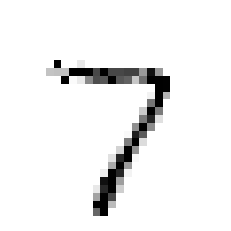

In [ ]:
plt.imshow(clean_digit.reshape(28,28), cmap='binary')
plt.axis('off');